#**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


#**Imports**

In [ ]:
import torchvision.transforms.functional as TF
import sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
from torchvision.models.resnet import resnet50
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
from google.colab.patches import cv2_imshow
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchsummary import summary
import torchvision
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

#**Paths**

In [ ]:

data_path ="/content/drive/MyDrive/EAI/Dataset_mix_Sharp_CLAHE_Bilateral"
train_path ="/content/drive/MyDrive/EAI/Dataset_mix_Sharp_CLAHE_Bilateral/train"
test_path ="/content/drive/MyDrive/EAI/Dataset_mix_Sharp_CLAHE_Bilateral/test"
val_path ="/content/drive/MyDrive/EAI/Dataset_mix_Sharp_CLAHE_Bilateral/val"


In [ ]:
data_path = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet'
train_path = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub3/train'
test_path = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub3/test'
val_path = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/Wavelet_Abs_Plt_Jet/sub3/val'
#train_nonsocial = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/train/nonsocial/'
#test_nonsocial = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/test/nonsocial/'
#val_nonsocial = '/content/drive/MyDrive/Tirocinio/Datasets/SocialMemoryImgs/val/nonsocial/'

In [ ]:
'''
data_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug"
train_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug/train"
test_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug/test"
val_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug/val"
'''

'\ndata_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug"\ntrain_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug/train"\ntest_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug/test"\nval_path ="/content/drive/MyDrive/EAI/Dataset_Mix_Aug/val"\n'

#**Preparo il trasformatore**

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

#**Carico il dataset in train, path e val trasformandolo direttamente con il trasformatore**

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_path, transform = val_transforms)

#**Suddivido in dataloader per velocizzare l'allenamento**

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle=True)

#**Calcolo della mean e std per la normalizzazione valido sia per Grayscale che RGB, basta modificare il trasformatore**

In [ ]:
def mean_and_std(loader):

  channels_sum, channels_squared_sum, num_batches = 0, 0, 0

  for images, _ in loader:
    channels_sum += torch.mean(images, dim=[0,2,3])
    channels_squared_sum += torch.mean(images**2, dim=[0,2,3])
    num_batches += 1

  mean = channels_sum/num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5

  return mean, std

#**Trasformatori completi anche di normalizzazione**

In [ ]:
mean, std = mean_and_std(train_loader)

train_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      #transforms.CenterCrop((224,192)),
      #transforms.RandomHorizontalFlip(),
      #transforms.RandomRotation(5),
      #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.67, fill=0), #probability=0.67 per le indicazioni del medico
      transforms.ToTensor(),
      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
      
])

val_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
      
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_path, transform = val_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle=True)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([29, 3, 224, 224])
torch.Size([3, 224, 224])
Grid Shape torch.Size([3, 1810, 906])
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1])


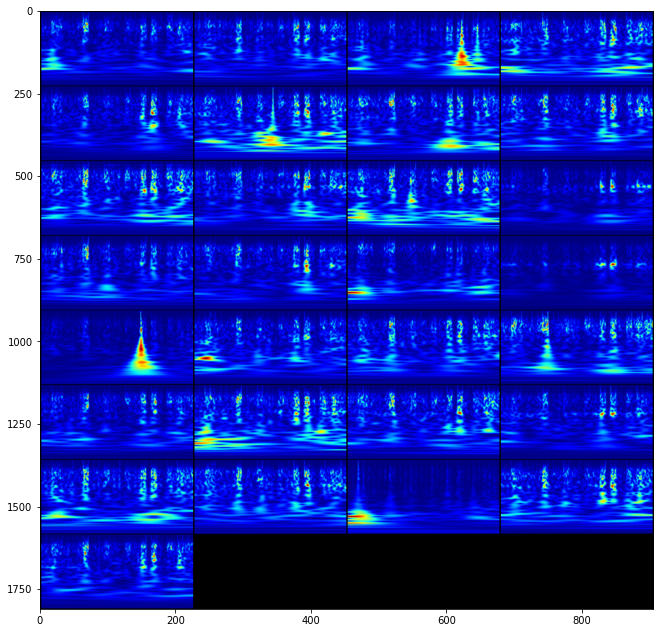

In [ ]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 29, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    print(type(images))
    print(type(images[0]))
    print(np.shape(images))
    print(np.shape(images[0]))

    grid = torchvision.utils.make_grid(images, nrow = 4)
    print(f'Grid Shape', np.shape(grid))
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)), aspect='auto', cmap= 'jet')
    plt.imsave('grid.png', np.transpose(grid, (1,2,0)).numpy(), cmap= 'jet')
    print("Labels:", labels)


show_transformed_images(train_dataset)

In [ ]:
plt.imsave('grid.png', np.transpose(grid, (1,2,0)), cmap= 'jet')

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [ ]:
plot_train_acc = []
plot_val_acc = []
plot_train_loss = []
lrs = []

def train_nn(model, train_loader, val_loader, optimizer, criterion, n_epochs):
  device = set_device()
  best_acc = 0
  #optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9, weight_decay=0.003, dampening=0.1)
  #optimizer = optim.RMSprop(model.parameters(), lr=0.02, momentum=0.9, weight_decay=0.003)
  #scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.89718207574)
  for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch + 1))
    model.train()
    curr_loss = 0.0
    curr_true = 0.0
    total = 0
    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0) #perche anche se il batch è da 32 l'ultimo potrebbe essere più piccolo
      optimizer.zero_grad()

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1) #l'1 specifica il one dimension reduce

      loss = criterion(outputs, labels)

      loss.backward()
      
      optimizer.step()
      #lrs.append(scheduler.get_last_lr())

      #scheduler.step()
      #lr = optimizer.param_groups[0]['lr']
      #print('lr = ', lr)

      curr_loss += loss.item()
      curr_true += (labels==predicted).sum().item()

    epoch_loss = curr_loss/len(train_loader)
    epoch_accuracy = (curr_true/total)*100
    plot_train_acc.append(epoch_accuracy)
    plot_train_loss.append(epoch_loss)
    #scheduler.step()

    print("   -- Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f" %(curr_true, total, epoch_accuracy, epoch_loss))

    val_acc = evaluate_model_val(model, val_loader)
    plot_val_acc.append(val_acc)


    if(val_acc >= best_acc):
      best_acc = val_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
      save_best_model(model)

  print("\n  -- Done!")
  return model

In [ ]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
      'comments': ' -- SUB 5O CON 10 -- '
  }
  torch.save(state, 'checkpoint.pth.tar')

In [ ]:
def save_best_model(model):
  torch.save(model, 'best_model.pth.tar')

In [ ]:
def evaluate_model_val(model, val_loader):
  model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for data in val_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      true_predicted_on_epoch += (predicted==labels).sum().item()

    epoch_accuracy = (true_predicted_on_epoch/total)*100

    print("   -- Val Dataset. Got %d out of %d images correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))

  return epoch_accuracy


In [ ]:
model = models.resnet50(pretrained=True)
#model = models.vgg11(pretrained = True)
num_features = model.fc.in_features
num_classes = 2
model.fc = nn.Linear(num_features, num_classes)
device = set_device()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5, dampening=0.1)
#optimizer1 = optim.Adam(model.parameters(), lr=0.0001)
#optimizer_med = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.003, dampening=0.1)
#optimizer2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003, dampening=0.1)
#optimizer= optim.Rprop(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#model.named_parameters
batch_t_range = range(0,40)
batch_te_range = range(0,10)
images_total_t = []
images_total_te = []
labels_total_t = []
labels_total_te = []

model = models.resnet50(pretrained=True)
model.fc = nn.Identity()

for batch_train in train_loader:
  images_t, labels_t = batch_train
  images_t = images_t.to(device)
  labels_t = labels_t.to(device)
  labels_t = labels_t.item()
  labels_total_t.append(labels_t)
  features_t = model(images_t)
  features_t = features_t.cpu().detach().numpy()
  images_total_t.append(features_t)

images_total_t = np.squeeze(images_total_t)


for batch_test in test_loader:
  images_te, labels_te = batch_test
  images_te = images_te.to(device)
  labels_te = labels_te.to(device)
  labels_te = labels_te.item()
  labels_total_te.append(labels_te)
  features_te = model(images_te)
  features_te = features_te.cpu().detach().numpy()
  images_total_te.append(features_te)

images_total_te = np.squeeze(images_total_te)

train_data_flatt = images_total_t
test_data_flatt = images_total_te
train_labels = labels_total_t
test_labels = labels_total_te

In [ ]:


print(train_labels)
print(test_labels)
print(np.shape(train_labels))
print(np.shape(test_labels))

print(np.shape(images_total_t))
print(np.shape(images_total_te))

In [ ]:
def ml_classification(train_data_flatt, train_labels, test_data_flatt):
    # --SVM--
    #Create a svm Classifier
    svm_clf = svm.SVC(kernel='rbf') # Linear Kernel

    #Train the model using the training sets
    svm_clf.fit(train_data_flatt, train_labels)

    #Predict the response for test dataset
    y_pred_svm = svm_clf.predict(test_data_flatt)

    # --RandomForest--

    rf_clf = RandomForestClassifier()

    rf_clf.fit(train_data_flatt, train_labels)

    y_pred_rf = rf_clf.predict(test_data_flatt)

     # --XGBoost--

    xgb_clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)

    xgb_clf.fit(train_data_flatt, train_labels)

    y_pred_xgb = xgb_clf.predict(test_data_flatt)

    print('SVM: ', metrics.accuracy_score(test_labels, y_pred_svm))
    print('RandomForest: ', metrics.accuracy_score(test_labels, y_pred_rf))
    print('XGBoost: ', metrics.accuracy_score(test_labels, y_pred_xgb))
    print('---------------------------------------------------------------')

In [ ]:
ml_classification(train_data_flatt, train_labels, test_data_flatt)

In [ ]:
class OurNet(nn.Module):

    def __init__(self):
        super().__init__()

        # ResNet50
        self.network = model
        
        # Replace last layer
        self.network._fc = nn.Sequential(nn.Conv2d(2048,512,(3, 3)),
                                         nn.Linear(512, 128), 
                                         nn.SELU(),
                                         nn.Dropout(0.6),
                                         nn.BatchNorm2d(128),
                                         nn.Linear(128, 32), 
                                         nn.SELU(),  
                                         nn.Dropout(0.5),
                                         nn.BatchNorm2d(32),
                                         nn.Linear(32,num_classes))
    
    def forward(self, x):
        out = self.network(x)
        return out

model = OurNet()

In [ ]:
#summary(model,(3, 64, 7))

In [ ]:
train_nn(model, train_loader, val_loader, optimizer, loss_fn, 200)

Epoch number 1
   -- Training Dataset. Got 99 out of 158 images correctly (62.658%). Epoch Loss: 0.659
   -- Val Dataset. Got 13 out of 22 images correctly (59.091%)
Epoch number 2
   -- Training Dataset. Got 108 out of 158 images correctly (68.354%). Epoch Loss: 0.599
   -- Val Dataset. Got 16 out of 22 images correctly (72.727%)
Epoch number 3
   -- Training Dataset. Got 130 out of 158 images correctly (82.278%). Epoch Loss: 0.489
   -- Val Dataset. Got 15 out of 22 images correctly (68.182%)
Epoch number 4
   -- Training Dataset. Got 129 out of 158 images correctly (81.646%). Epoch Loss: 0.466
   -- Val Dataset. Got 15 out of 22 images correctly (68.182%)
Epoch number 5
   -- Training Dataset. Got 136 out of 158 images correctly (86.076%). Epoch Loss: 0.392
   -- Val Dataset. Got 16 out of 22 images correctly (72.727%)
Epoch number 6
   -- Training Dataset. Got 137 out of 158 images correctly (86.709%). Epoch Loss: 0.352
   -- Val Dataset. Got 15 out of 22 images correctly (68.182%)

OurNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
checkpoint = torch.load('checkpoint.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
print(checkpoint['comments'])

171
86.36363636363636
 -- SUB 5O CON 10 -- 


In [ ]:
best_model = torch.load('best_model.pth.tar')

In [ ]:
def showBadPredictedImages(predicteds, labels, imgs):
  for i in range(len(labels)):
    if predicteds[i] != labels[i]: #se la label predictada è diversa da quella effettiva
      print("label: ", labels[i], "predicted: ", predicteds[i])
      img = imgs[i].permute(1, 2, 0) 
      plt.figure()
      plt.imshow(img.numpy())
      plt.show()
      print("\n")

In [ ]:
all_pred = []
all_true = []
all_imgs = []

def evaluate_model_test(best_model, test_loader):

  best_model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()
  all_imgs = []
  #all_true = []
  
  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for data in test_loader:
      images, labels = data

      for img in images:
        all_imgs.append(img) #mi salvo in una lista le immagini per ogni batch alla fine le avrò tutte
      for lab in labels:
        all_true.append(float(lab)) #mi salvo in una lista le labels per ogni batch alla fine le avrò tutte

      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)
     
      outputs = best_model(images)

      _, predicted = torch.max(outputs.data, 1)
      for pred in predicted:
        all_pred.append(float(pred)) #mi salvo tutte le prediction


      true_predicted_on_epoch += (predicted==labels).sum().item()
    
    epoch_accuracy = (true_predicted_on_epoch/total)*100
  print("   -- Test Dataset. Got %d out of %d images correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))
  precisionEval = metrics.precision_score(all_true, all_pred, zero_division=1)
  recallEval =  metrics.recall_score(all_true, all_pred, zero_division=1)
  f1Score = metrics.f1_score(all_true, all_pred, zero_division=1)
  print("   -- Test Dataset, recall: ", recallEval)
  print("   -- Test Dataset, precision: ", precisionEval)
  print("   -- Test Dataset, f1 score: ", f1Score)
  #showBadPredictedImages(all_pred, all_true, all_imgs)
  return epoch_accuracy

In [ ]:
test_acc = evaluate_model_test(best_model, test_loader)

   -- Test Dataset. Got 38 out of 44 images correctly (86.364%)
   -- Test Dataset, recall:  0.9090909090909091
   -- Test Dataset, precision:  0.8333333333333334
   -- Test Dataset, f1 score:  0.8695652173913043


##**Plots**

##**Confusion Matrix**

In [ ]:
def plotConfMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["normal", "abnormal"]
    plotConfMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()


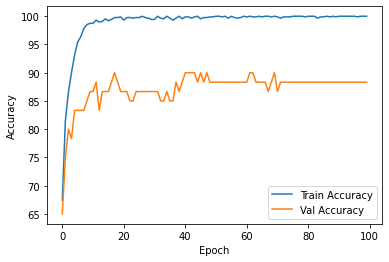

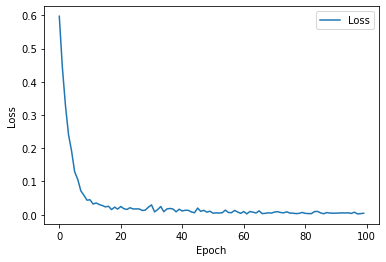

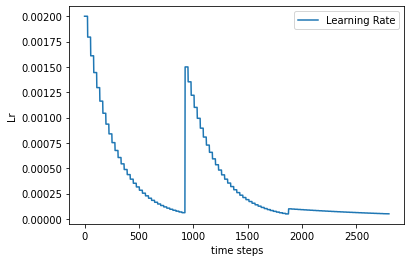

[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0,

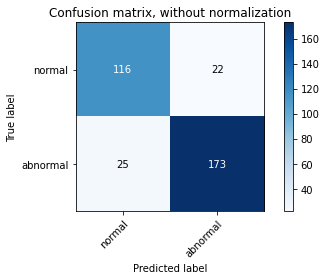

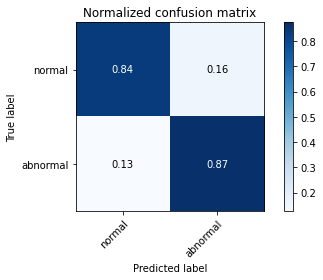

Confusion matrixes plotted.


In [ ]:
plt.plot(plot_train_acc, label = "Train Accuracy")
plt.plot(plot_val_acc, label = "Val Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(plot_train_loss, label = "Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(lrs, label = "Learning Rate")
plt.xlabel('time steps')
plt.ylabel('Lr')
plt.legend()
plt.show()
print(all_true)
print(all_pred)

plotConfusions(all_true, all_pred)

print("Confusion matrixes plotted.")